# Neural network prediction for the sPOD-DL-ROM for CombustionWaveTA

In [1]:
import sys
sys.path.append('LIB/')
sys.path.append('LIB/sPOD/lib/')
sys.path.append('LIB/DL_LIB/sPOD_DL_ROM/')

In [2]:
from CombustionWaveTA import CombustionWaveTA
import numpy as np

## Data generation / Shifted POD of the data

Check 1...
Relative time amplitude error for online prediction(interpolation) for num modes 5 is 0.0009265963425015743
Relative time amplitude error for online prediction(interpolation) for num modes 5 is 0.00098133537165524
Relative shift error for online prediction(interpolation) for num modes 5 is 6.901861674987081e-17
Relative shift error for online prediction(interpolation) for num modes 5 is 6.901861674987081e-17


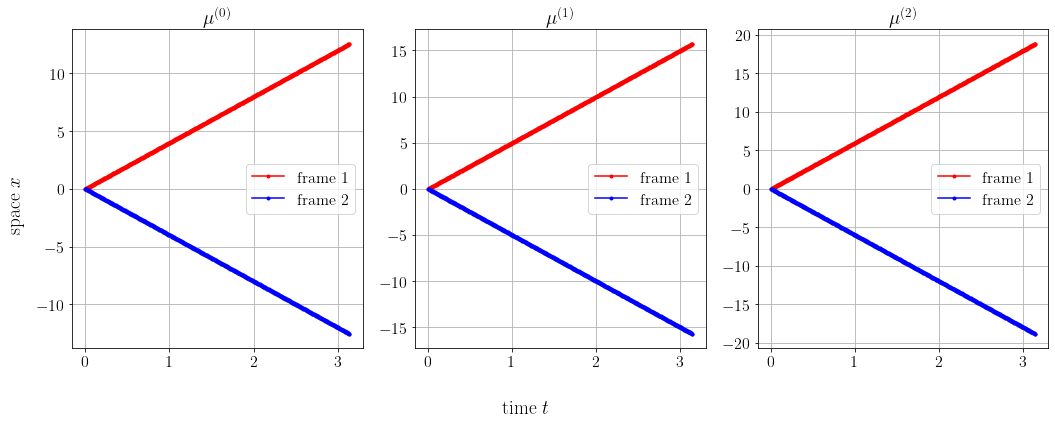

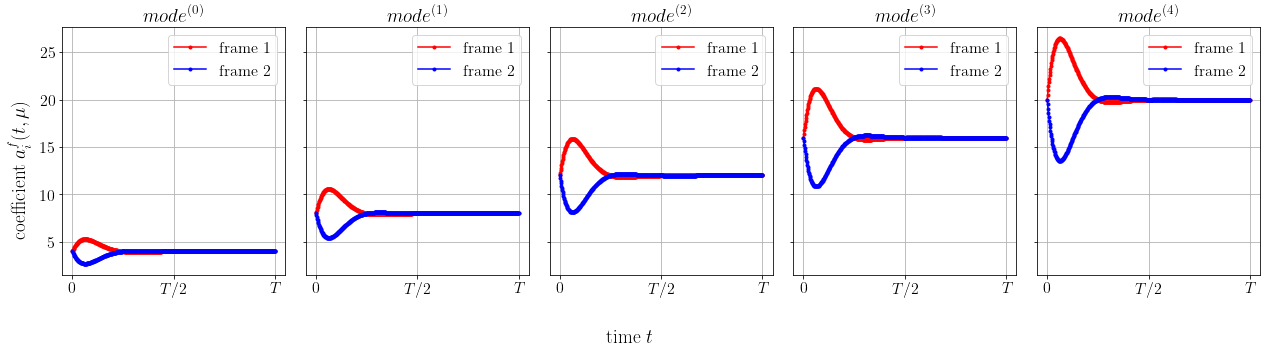

In [3]:
df = CombustionWaveTA()        

## Input data for the network 

In [4]:
# We collect the time amplitudes, shifts and the parameters for the training as well as the testing data.
TA_TRAIN = df.TA_TRAIN
SHIFTS_TRAIN = df.SHIFTS_TRAIN
PARAMS_TRAIN = df.PARAMS_TRAIN
TA_TEST = df.TA_TEST
SHIFTS_TEST = df.SHIFTS_TEST
PARAMS_TEST = df.PARAMS_TEST

In [5]:
print("Grid, Nx : {}, Nt : {}".format(df.Nx, df.Nt))
print("Number of sPOD frames : {}".format(df.NumFrames))
print("Number of modes per frame : {}".format(df.nmodes))
print("Number of parameter instances : {}".format(int(int(TA_TRAIN.shape[1]) / df.Nt)))
print("Size of training matrix : {} x {}".format(int(TA_TRAIN.shape[0]), int(TA_TRAIN.shape[1])))

Grid, Nx : 500, Nt : 500
Number of sPOD frames : 2
Number of modes per frame : 5
Number of parameter instances : 3
Size of training matrix : 10 x 1500


In [6]:
# This cell is reserved for any data manipulations that need to be done for the network input
shifts_train = np.concatenate((np.reshape(SHIFTS_TRAIN[0], newshape=[1, -1]), np.reshape(SHIFTS_TRAIN[1], newshape=[1, -1])), axis=0)
shifts_test = np.concatenate((np.reshape(SHIFTS_TEST[0], newshape=[1, -1]), np.reshape(SHIFTS_TEST[1], newshape=[1, -1])), axis=0)

# Data manipulation for network input
ta_train = np.concatenate((TA_TRAIN, shifts_train), axis=0)
ta_test = np.concatenate((TA_TEST, shifts_test), axis=0)

## Network call

## Feed forward neural network

In [7]:
# Path for the pretrained weights
PATH = 'DNN/onlyTA/training_results_local_sPOD/2022_08_24__18-32-23/trained_weights/weights.pt'

In [8]:
params = {
        'scaling': True,  # true if the data should be scaled
        'full_order_model_dimension': df.Nx,  # N_h
        'reduced_order_model_dimension': df.nmodes * df.NumFrames + df.NumFrames,  # N
        'totalModes': df.nmodes * df.NumFrames,  # Total number of modes for all the frames
        'NumOfFrames': df.NumFrames  # Total number of frames
    }

In [9]:
# training the model
from network import run_model 
print("#################################")
print("sPOD-DL-ROM")
trained_model, scaling = run_model(ta_train, PARAMS_TRAIN, epochs=50000, lr=0.05, loss='L1',
                 logs_folder='./DNN/onlyTA/training_results_local_sPOD',
                 pretrained_load=False, pretrained_weights=PATH, params=params)
print("#################################\n")

#################################
sPOD-DL-ROM
Average loss at epoch 0 on training set: 0.8157298962275187
Average loss at epoch 500 on training set: 0.06791011989116669
Average loss at epoch 1000 on training set: 0.0331583439062039
Average loss at epoch 1500 on training set: 0.03204135845104853
Average loss at epoch 2000 on training set: 0.033632190277179085
Average loss at epoch 2500 on training set: 0.033659606551130615
Average loss at epoch 3000 on training set: 0.03171607541541258
Average loss at epoch 3500 on training set: 0.027924663697679836
Average loss at epoch 4000 on training set: 0.03167976873616377
Average loss at epoch 4500 on training set: 0.03235802551110586
Average loss at epoch 5000 on training set: 0.02161988926430543
Average loss at epoch 5500 on training set: 0.0160660104205211
Average loss at epoch 6000 on training set: 0.014111692396303019
Average loss at epoch 6500 on training set: 0.014616575402518114
Average loss at epoch 7000 on training set: 0.01374075654894

In [10]:
# load the model
import torch
import pathlib
import os

log_folder_base = 'DNN/onlyTA/training_results_local_sPOD/'
log_folder_trained_model = sorted(pathlib.Path(log_folder_base).glob('*/'), key=os.path.getmtime)[-1]
PATH = str(log_folder_trained_model) + '/trained_weights/' + 'weights.pt'
print(PATH)

DNN/onlyTA/training_results_local_sPOD/2022_08_25__12-34-47/trained_weights/weights.pt


In [11]:
from network import scale_params
PARAMS_TEST = scale_params(PARAMS_TEST, params, scaling)

In [14]:
# testing the model
from network import test_model 
rel_err, results_predicted = test_model(TA_TEST=ta_test, params_test=PARAMS_TEST, 
                                        model=trained_model, saved_model=True, 
                                        PATH_TO_WEIGHTS=PATH, params=params, 
                                        scaling=scaling) 
print(rel_err)

0.010199349


## Convolutional autoencoder and DNN coupled model

In [ ]:
from TrainingFramework import TrainingFramework
from TestingFramework import TestingFramework
import Helper

In [ ]:
dict_network = {
        'time_amplitude_train': ta_train,
        'time_amplitude_test': ta_test,
        'parameter_train': PARAMS_TRAIN,
        'parameter_test': PARAMS_TEST,
        'batch_size': 500,
        'num_early_stop': 1500,  # Number of epochs for the early stopping
        'pretrained_load': False,  # Whether to initialize the network with pretrained weights
        'scaling': False,  # true if the data should be scaled
        'perform_svd': 'randomized',  # '', 'normal', 'randomized'
        'learning_rate': 0.005,  # eta
        'full_order_model_dimension': df.Nx,  # N_h
        'reduced_order_model_dimension': df.nmodes * df.NumFrames + df.NumFrames,  # N
        'encoded_dimension': 4,  # dimension of the system after the encoder
        'omega_h': 0.8,
        'omega_N': 0.2,
        'typeConv': '1D',  # Type of convolutional layer for the network : '1D' or '2D'
        'totalModes': df.nmodes * df.NumFrames,  # Total number of modes for all the frames
        'NumOfFrames': df.NumFrames  # Total number of frames
    }

In [ ]:
# select the path to the pre trained weights
PATH = 'CADNN/onlyTA/training_results_local_sPOD/2022_08_23__19-55-17/net_weights/epoch_99.pt'

In [ ]:
# Training model
train_model = TrainingFramework(dict_network, split=0.60, log_folder='./CADNN/onlyTA/training_results_local_sPOD')
trained_model = train_model.training(epochs=5000, save_every=500, print_every=500, 
                                     log_base_name='/', pretrained_weights=PATH)

In [ ]:
import os
import pathlib

# Testing model
testing_method = ''

log_folder_base = 'CADNN/onlyTA/training_results_local_sPOD/'
log_folder_trained_model = sorted(pathlib.Path(log_folder_base).glob('*/'), key=os.path.getmtime)[-1]

test_model = TestingFramework(dict_network)
test_model.testing(log_folder_trained_model=str(log_folder_trained_model), 
                   testing_method=testing_method, model=trained_model)
results_predicted = test_model.time_amplitude_test_output

## Online error analysis

In [15]:
# Data manipulation for error analysis
frame_amplitudes_predicted = results_predicted[:-2, :]
shifts_predicted = results_predicted[-2:, :]

#############################################
Online Error checks
Check 1...
Relative time amplitude error indicator for frame: 1 is 0.012286209391517634
Relative time amplitude error indicator for frame: 2 is 0.007520146600315429
Check 2...
Relative error indicator for shift: 1 is 0.007241806535753339
Relative error indicator for shift: 2 is 0.00859167081784513


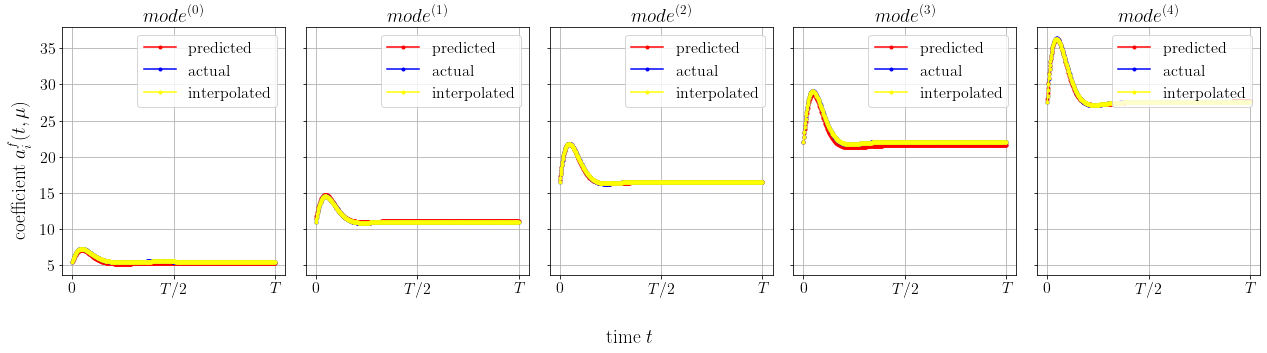

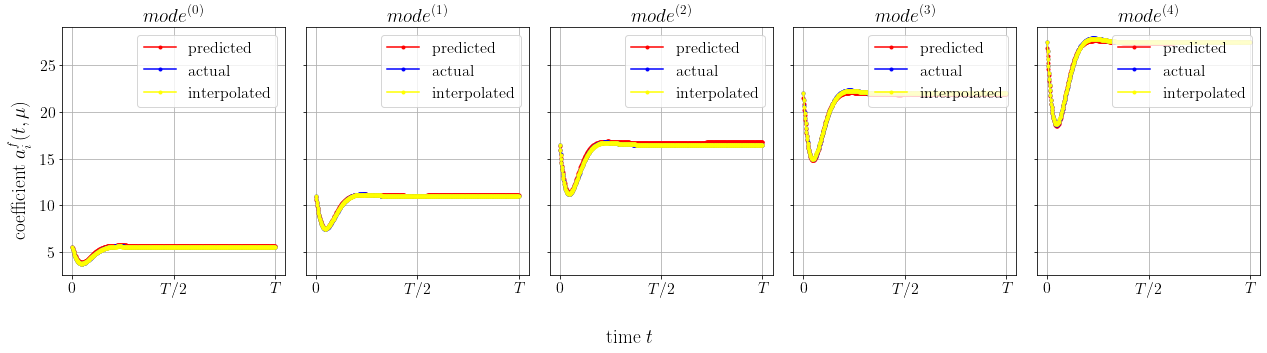

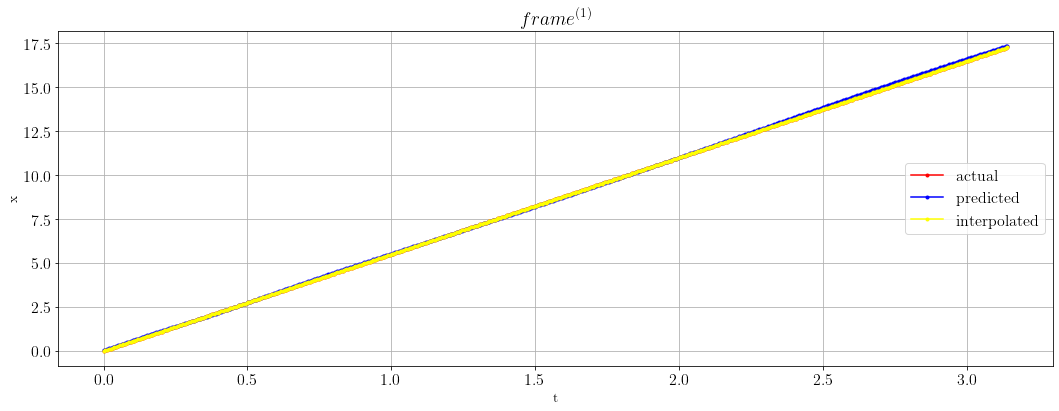

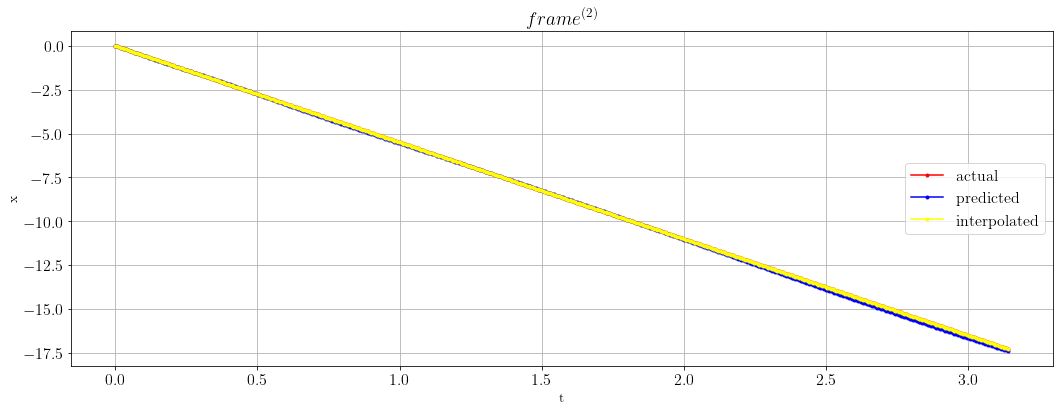

In [16]:
df.onlineErroranalysis(frame_amplitudes_predicted, shifts_predicted)